In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Module 11 Lab - Model Evaluation

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Blackboard.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

1. Show all work/steps/calculations using Code and Markdown cells.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear

sns.set(style="whitegrid")


# load whatever other libraries you need including models.py
import models

## Model Evaluation and Improvement

As we saw in both the Linear Regression and Logistic Regression modules, there is a Statistician's view of Model Evaluation (and perhaps, Improvement) and a Machine Learning view of Model Evaluation and Improvement.

We'll be working with the **insurance data**.

**1. Load the data, perform your transformations, and using the Bootstrap version of the Linear Regression function, estimate your final model from Lab 10 and show the Bootstrap results**

Let's use the model produced at the end of the Lab 10 solution:

"charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children"

Let's load up the data, and create the transformations listed

In [4]:
data = pd.read_csv("insurance.csv")

data["age_sq"]       = data.age * data.age
data["smoke_yes"]    = pd.get_dummies(data.smoker, prefix="smoke").smoke_yes
data["male"]         = pd.get_dummies(data.sex).male
data["bmi_above_30"] = (data.bmi > 30).map({True: 1, False: 0})
data

,age,sex,bmi,children,smoker,region,charges,age_sq,smoke_yes,male,bmi_above_30
0,19,female,27.900,0,yes,southwest,16884.92400,361,1,0,0
1,18,male,33.770,1,no,southeast,1725.55230,324,0,1,1
2,28,male,33.000,3,no,southeast,4449.46200,784,0,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1089,0,1,0
4,32,male,28.880,0,no,northwest,3866.85520,1024,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,2500,0,1,1
1334,18,female,31.920,0,no,northeast,2205.98080,324,0,0,1
1335,18,female,36.850,0,no,southeast,1629.83350,324,0,0,1
1336,21,female,25.800,0,no,southwest,2007.94500,441,0,0,0


In [5]:
model = "charges ~ age_sq + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children"
final = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(final)

Our results are indeed pretty good. 

**2. Perform three rounds of 10-fold cross validation, estimating $R^2$ and $\sigma$ each round. Using the results for the test data, calculate 95% Bootstrap estimates of the credible intervals for each.** Comment on these intervals and the intervals from above. Are the average values different? Are the intervals different?

To do this, we'll use sklearn's `cross_val_score`. However, first we need to get our model into a form that sklearn can take in and evaluate. 

In [6]:
y, X = patsy.dmatrices(model, data, return_type="matrix")
reg = linear.LinearRegression()

In [7]:
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [8]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
R2s = cross_val_score(estimator = reg, X = X, y = y, cv = cv)
R2s

array([0.88200657, 0.89374155, 0.86889218, 0.85295221, 0.94917338,
       0.86017784, 0.84655537, 0.77446399, 0.83321713, 0.87561323,
       0.79893548, 0.94441111, 0.81031815, 0.92460551, 0.90966819,
       0.86769227, 0.84683167, 0.836579  , 0.90736098, 0.85525215,
       0.92950911, 0.94280255, 0.87651198, 0.92745154, 0.83359276,
       0.79143157, 0.84175431, 0.74746667, 0.85269734, 0.88589089])

As we can see, `RepeatedKFold` did the 10 splits 3 times.

sklearn's `LinearRegression` uses $R^2$ as its scoring method, so the numbers we see above are the various $R^2$ values for each fold. But we need both $R^2$ and $\sigma$, so let's define our own scoring function that calculates $\sigma$ and combine those scores with our $R^2$ scores.

In [9]:
def calc_sigma(model, X, y):
    result = {}
    coefficients = model.coef_[0]

    y_hat = model.predict(X)
    residuals = y - y_hat
    
    sum_squared_error = sum(e ** 2 for e in residuals)[0]

    n = len(residuals)
    k = len(coefficients)

    sigma = np.sqrt(sum_squared_error / (n - k))
    return sigma

In [10]:
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
sigmas = cross_val_score(estimator = reg, X = X, y = y, cv = cv, scoring = calc_sigma)

Now that we have results for both (and both started with the same random seed so they give the same splits), we can carry out bootstrapping to get our results. 

In [11]:
def bootstrap_sample(data, f, n=100):
    m = len(data)
    return np.array(
        [f(np.random.choice(data, len(data), replace=True)) for _ in range(n)]
    )

In [12]:
R2_posterior    = bootstrap_sample(data = R2s   , f = np.mean, n = 500)
sigma_posterior = bootstrap_sample(data = sigmas, f = np.mean, n = 500)

In [13]:
stats.mstats.mquantiles(R2_posterior, prob = [0.025, 0.975])

array([0.8482992 , 0.88233207])

The 95% BCI for the $R^2$ of our model is 0.847 to 0.886

In [14]:
stats.mstats.mquantiles(sigma_posterior, prob = [0.025, 0.975])

array([4119.15477369, 4742.40386131])

The 95% BCI for the $\sigma$ of our model is 4163 to 4735

**3. Using Learning Curves and $\sigma$ determine if more data will improve the estimation of the model.**

In [15]:
from useful_funcs import plot_learning_curve

<module 'matplotlib.pyplot' from '/Users/natemcintosh/miniconda3/envs/en685648/lib/python3.8/site-packages/matplotlib/pyplot.py'>

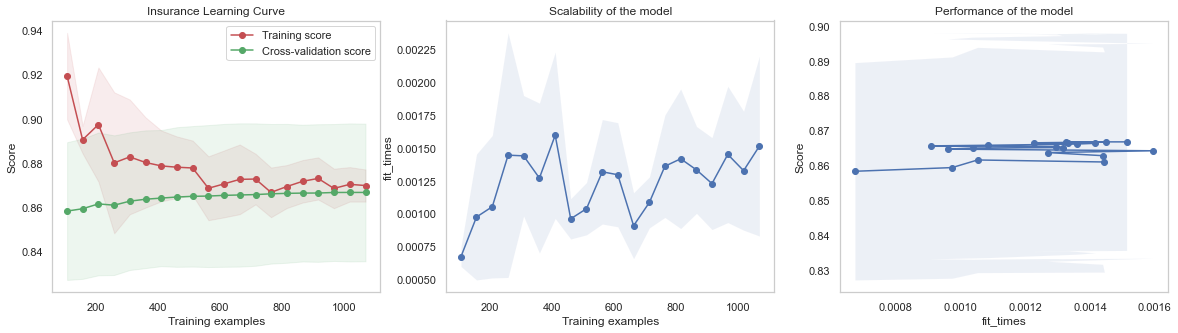

In [16]:
plot_learning_curve(
    estimator=linear.LinearRegression(),
    title="Insurance Learning Curve",
    X=X,
    y=y,
    cv=5,
    train_sizes=np.linspace(0.1, 1, 20)
)

The training score and the cross-validation score certainly seem to converge. By the time 600 training samples are reached, the two dots seem to overlap almost completely, then separate, then almost merge again. This suggests that collecting more data probably will not assist in improving the model. 

**4. It was shown that `age_sq` improved the performance of the model. Perhaps a different polynomial would have been better. Generate Validation Curves for `age` = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5] and select the best transformation.**

In [18]:
from copy import deepcopy

def mse( errors):
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)


def cross_validate( formula, data, test_size=0.20):
    training_mses = []
    test_mses = []
    
    n = data.shape[ 0]
    test_n = int( np.round( test_size * n, 0))

    indices = deepcopy( data.index).values
    random.shuffle( indices)

    test_indices = indices[ 0:test_n]
    training_indices = indices[test_n:]

    test_set = data.iloc[ test_indices]
    training_set = data.iloc[ training_indices]

    y, X = patsy.dmatrices( formula, training_set, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)
    y_hat = model.predict( X)

    training_mse = mse( y - y_hat)

    y, X = patsy.dmatrices( formula, test_set, return_type="matrix")
    y_hat = model.predict( X)

    test_mse = mse( y - y_hat)

    return training_mse, test_mse

def validation_curves( formulas, data, iterations=100, test_size=0.2):
    train = []
    test = []
    for formula in formulas:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            train_mse, test_mse = cross_validate( formula, data, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    print(train)
    print(test)
    return train, test

ages = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
age_vectors = np.hstack([(data.age**age).values.reshape(-1,1) for age in ages])
age_strs    = ["age_"+str(expon).replace(".","_") for expon in ages]
age_df      = pd.DataFrame(age_vectors, columns = age_strs)

data2 = pd.concat([data, age_df], axis=1)

formulas = [
    "charges ~ " + age_str + " + male + bmi + smoke_yes + smoke_yes:bmi + smoke_yes:bmi_above_30 + children"
    for age_str in age_strs
]

train, test = validation_curves(formulas, data2)


[4370.608627347092, 4371.4814024280895, 4365.836034486104, 4355.726741715289, 4356.145309771804, 4359.446987317504, 4376.503864615956, 4375.063683395842, 4359.125558802505, 4378.977087314988, 4379.5286396606125]
[4384.99729642085, 4362.976775497591, 4376.976112138851, 4405.030207026502, 4394.704009356157, 4378.556910593253, 4311.74004960692, 4320.995571746836, 4383.638440731883, 4320.302710967857, 4327.034787914401]


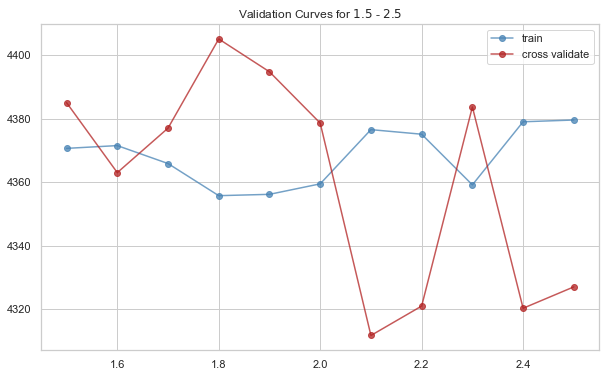

In [19]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( ages, train, 'o-', color="steelblue", alpha=0.75, label="train")
axes.plot( ages, test, "o-", color="firebrick", alpha=0.75, label="cross validate")

axes.set_title( "Validation Curves for $1.5$ - $2.5$")
axes.legend()

plt.show()
plt.close()

This definitely does not have the shape we would like it to. Ideally, the training error would steadily decrease, and the cross validation would form a "u" shape. From this, it is essentially impossible to pick one exponent over another

**5. Using Ridge Regression to estimate a model for the insurance data. Compare it with your final Linear Regression model.** (If you get far ahead, you may need to write your own function. Here are the sklearn docs: http://scikit-learn.org/stable/modules/linear_model.html)

In [20]:
from sklearn.linear_model import Ridge

In [21]:
ridge = Ridge()
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
ridge_R2s = cross_val_score(estimator = ridge, X = X, y = y, cv = cv)

In [22]:
np.random.seed(100)
ridge_R2_posterior = bootstrap_sample(ridge_R2s, np.mean, n = 500)
difference = R2_posterior - ridge_R2_posterior

Now that we bootstrapped $R^2$ for ridge regression, let's compare that to the bootstrapped $R^2$ for linear regression. Let's say that a region of practical equivalence is within 3%. 

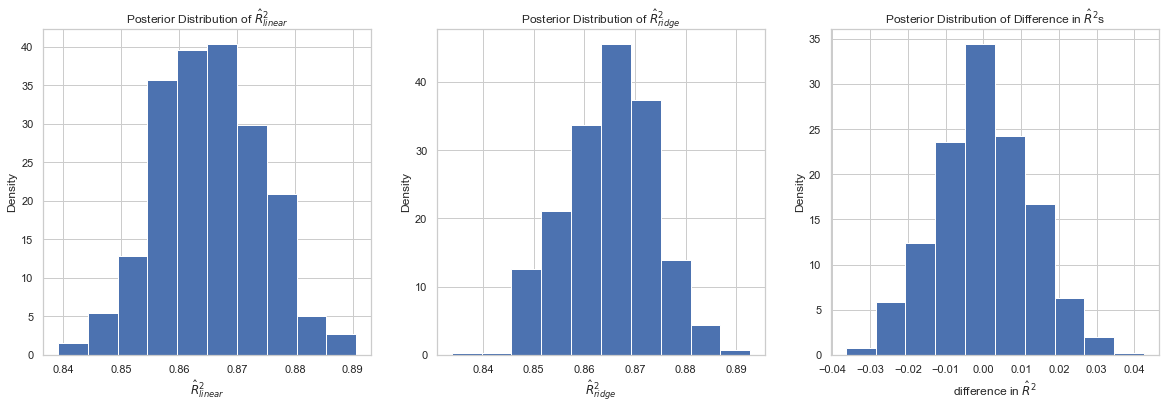

In [23]:
figure = plt.figure(figsize=(20, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist( R2_posterior, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$\hat{R}^2_{linear}$")
axes.set_title( "Posterior Distribution of $\hat{R}^2_{linear}$")

axes = figure.add_subplot(1, 3, 2)

axes.hist( ridge_R2_posterior, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$\hat{R}^2_{ridge}$")
axes.set_title( "Posterior Distribution of $\hat{R}^2_{ridge}$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "difference in $\hat{R}^2$")
axes.set_title( "Posterior Distribution of Difference in $\hat{R}^2$s")

plt.show()
plt.close()

Looking at the differences, it looks like almost all the differences are within 3% either way. 

In [24]:
(np.abs(difference) <= 0.03).mean()

0.984

There is a 99% chance that the difference between the scores of the two regression methods is within the ROPE that we set as 3%. That said, we, the data scientists, did far less work to get the ridge regression result